In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):  
    for filename in filenames:
        print(os.path.join(dirname, filename))     

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/6-am-to-3-pm-traffic-dataset/6am-3pm_five_minute_vehicle_counts_.csv
/kaggle/input/traffic-dataset-suppressed/Reconstructed_Total.csv


In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import LSTM, Dense   
from tensorflow.keras.layers import GRU, Dense  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error 
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.callbacks import EarlyStopping  
from kerastuner.tuners import RandomSearch  
from kerastuner.engine.hyperparameters import HyperParameters  

<ipython-input-1-badc51c3381a>:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [6]:
# Load and preprocess the dataset
data = pd.read_csv("/kaggle/input/6-am-to-3-pm-traffic-dataset/6am-3pm_five_minute_vehicle_counts_.csv")  # Replace with your file path

# Convert 'date' and 'time' into a single datetime column
data['datetime'] = data['date'] + ' ' + data['time'].str.split(' - ').str[0]
data['datetime'] = pd.to_datetime(data['datetime'], format='%d-%m-%Y %H:%M')
data = data[['datetime', 'Total']]


,datetime,Total
0,2024-09-19 06:00:00,128
1,2024-09-19 06:05:00,148
2,2024-09-19 06:10:00,180
3,2024-09-19 06:15:00,148
4,2024-09-19 06:20:00,142
...,...,...
1183,2024-09-29 14:35:00,173
1184,2024-09-29 14:40:00,184
1185,2024-09-29 14:45:00,189
1186,2024-09-29 14:50:00,247


In [ ]:
# Split data into training, validation, and test sets
train_data = data[(data['datetime'].dt.date >= pd.to_datetime('2024-09-19').date()) &
                  (data['datetime'].dt.date <= pd.to_datetime('2024-09-27').date())]

val_data = data[data['datetime'].dt.date == pd.to_datetime('2024-09-28').date()]

test_data = data[data['datetime'].dt.date == pd.to_datetime('2024-09-29').date()]
test_data.shape

In [ ]:
# Function to create sequences
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [ ]:
# Create training sequences without overlapping days
sequence_length = 15
train_sequences, train_targets = [], []
unique_dates = train_data['datetime'].dt.date.unique()
for date in unique_dates:
    daily_data = train_data[train_data['datetime'].dt.date == date]['Total'].values
    seqs, targets = create_sequences(daily_data, sequence_length)
    train_sequences.extend(seqs)
    train_targets.extend(targets) 


In [ ]:
# Prepare validation and test sequences
val_sequences, val_targets = create_sequences(val_data['Total'].values, sequence_length)
test_sequences, test_targets = create_sequences(test_data['Total'].values, sequence_length)
test_sequences.shape

## Generalized code

In [28]:
# Load and preprocess the dataset
data = pd.read_csv("/kaggle/input/6-am-to-3-pm-traffic-dataset/6am-3pm_five_minute_vehicle_counts_.csv")  # Replace with your file path

# Convert 'date' and 'time' into a single datetime column
data['datetime'] = data['date'] + ' ' + data['time'].str.split(' - ').str[0]
data['datetime'] = pd.to_datetime(data['datetime'], format='%d-%m-%Y %H:%M')
data = data[['datetime', 'Total']]

# Split data into training, validation, and test sets
train_data = data[(data['datetime'].dt.date >= pd.to_datetime('2024-09-19').date()) &
                  (data['datetime'].dt.date <= pd.to_datetime('2024-09-27').date())]

val_data = data[data['datetime'].dt.date == pd.to_datetime('2024-09-28').date()]

test_data = data[data['datetime'].dt.date == pd.to_datetime('2024-09-29').date()]

# Function to create sequences
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Create training sequences without overlapping days
sequence_length = 15
train_sequences, train_targets = [], []
unique_dates = train_data['datetime'].dt.date.unique()
for date in unique_dates:
    daily_data = train_data[train_data['datetime'].dt.date == date]['Total'].values
    seqs, targets = create_sequences(daily_data, sequence_length)
    train_sequences.extend(seqs)
    train_targets.extend(targets) 

# Prepare validation and test sequences
val_sequences, val_targets = create_sequences(val_data['Total'].values, sequence_length)
test_sequences, test_targets = create_sequences(test_data['Total'].values, sequence_length)

# Fit the scaler on the entire 'Total' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data['Total'].values.reshape(-1, 1))

# Scale the sequences
train_sequences = scaler.transform(np.array(train_sequences).reshape(-1, 1)).reshape(-1, sequence_length, 1)
val_sequences = scaler.transform(np.array(val_sequences).reshape(-1, 1)).reshape(-1, sequence_length, 1)
test_sequences = scaler.transform(np.array(test_sequences).reshape(-1, 1)).reshape(-1, sequence_length, 1)

# Scale the targets
train_targets = scaler.transform(np.array(train_targets).reshape(-1, 1))
val_targets = scaler.transform(np.array(val_targets).reshape(-1, 1))
test_targets = scaler.transform(np.array(test_targets).reshape(-1, 1))


In [10]:
print("Train sequences shape:", np.array(train_sequences).shape)  
print("Train targets shape:", np.array(train_targets).shape)  

Train sequences shape: (837, 15, 1)
Train targets shape: (837, 1)


## LSTM

#### Vanilla LSTM

- Build the  Vanilla LSTM Model, compile
- Train the model, use Early stop criteria

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(50, input_shape=(train_sequences.shape[1], 1),
        kernel_regularizer=l2(0.0001)
        ),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model
history = model.fit(
    train_sequences, train_targets,
    validation_data=(val_sequences, val_targets),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

### Stacked LSTM

- Build the Stacked LSTM Model, compile
- Train the model, use Early stop criteria

In [31]:
# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(train_sequences.shape[1], 1),
        kernel_regularizer=l2(0.0001), return_sequences=True,
        ),
    LSTM(32, kernel_regularizer=l2(0.0001)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history = model.fit(
    train_sequences, train_targets,
    validation_data=(val_sequences, val_targets),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0826 - val_loss: 0.0270
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0279 - val_loss: 0.0236
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0238 - val_loss: 0.0225
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0215 - val_loss: 0.0210
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0207 - val_loss: 0.0201
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0222 - val_loss: 0.0200
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0197 - val_loss: 0.0194
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0200 - val_loss: 0.0188
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0182 - val_loss: 0.0188
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0177 - val_loss: 0.0190
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0176 - val_loss: 0.0184
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

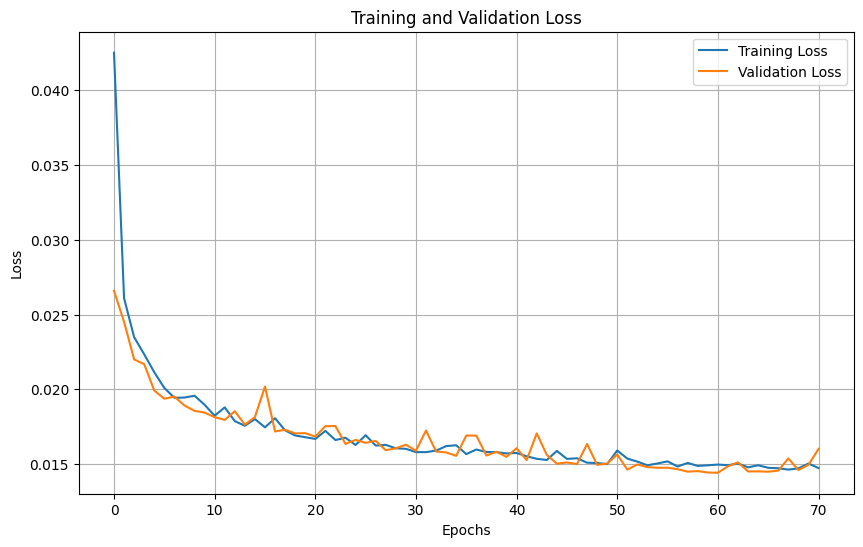

In [14]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend() 
plt.xlabel('Epochs') 
plt.ylabel('Loss')  
plt.title('Training and Validation Loss')    
plt.show() 

- Get prediction values
- Inverse Transform
- Evaluate

In [32]:
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(test_sequences) 

# Inverse scale the predictions and actual targets for comparison
predictions = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(test_targets.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_values, predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
Root Mean Squared Error (RMSE): 28.421156121152855
Mean Absolute Percentage Error (MAPE): 9.69%


## GRU With keras Tuning

- Impleting keras tuner for best hyperparameters
- Get the best parameters
- let's see those parameters

In [16]:
def build_model(hp):
    model = Sequential()
    model.add(GRU(
        hp.Int('input_unit', min_value=16, max_value=256, step=16),
        input_shape=(train_sequences.shape[1], 1),
        kernel_regularizer=l2(hp.Float('l2_regularizer', min_value=1e-5, max_value=1e-2, sampling='log')),
        return_sequences=False,
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'], default='relu')
    ))
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mean_squared_error", 
        metrics=["mse"]
    )
    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective="mse",
    max_trials=6,
    executions_per_trial=2,
    overwrite=True,
)

# Perform hyperparameter tuning
tuner.search(
    x=train_sequences,
    y=train_targets,
    #validation_data=(val_sequences, val_targets),
    epochs=10,
    batch_size=16,
)

# Get the best hyperparameters after the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]  # Get the best trial

# Print the optimal hyperparameters
print("The optimal hyperparameters are:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

Trial 6 Complete [00h 00m 23s]
mse: 0.02753173280507326

Best mse So Far: 0.015491663943976164
Total elapsed time: 00h 01m 57s
The optimal hyperparameters are:
input_unit: 192
l2_regularizer: 0.0006948789957181235
activation: tanh
Dropout_rate: 0.2
lr: 0.0007159994565305996


- Get prediction values
- Inverse Transform
- Evaluate

In [17]:
best_model = tuner.get_best_models(num_models=1)[0] 

GRU_predictions = best_model.predict(test_sequences)
# Inverse scale the predictions and actual targets for comparison
GRU_predictions = scaler.inverse_transform(GRU_predictions)
actual_values = scaler.inverse_transform(test_targets.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, GRU_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_values, GRU_predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Root Mean Squared Error (RMSE): 29.76655287372843
Mean Absolute Percentage Error (MAPE): 9.56%


- Create actual, LSTM values, GRU values Dataframe
- let's see the dataframe

In [ ]:
import matplotlib.pyplot as plt

# Plot Actual vs Prediction
plt.figure(figsize=(12, 6))
plt.plot(results_df['datetime'], results_df['actual_values'], label='Actual Values', color='darkviolet')
plt.plot(results_df['datetime'], results_df['LSTM_predictions'], label='LSTM_Predicted Values', color='red')
plt.plot(results_df['datetime'], results_df['GRU_predictions'], label='GRU_Predicted Values', color='green')
plt.title('Actual vs Predicted Vehicle Counts')
plt.xlabel('Datetime')
plt.ylabel('Vehicle Counts')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid()
plt.tight_layout()
#plt.savefig('LSTM,GRU Actual Vs Predicted.png', format='png')
plt.show()

## EMD-LSTM

In [26]:
# Load and preprocess the dataset
data = pd.read_csv("/kaggle/input/traffic-dataset-suppressed/Reconstructed_Total.csv")

# Convert 'date' and 'time' into a single datetime column
data['datetime'] = data['date'] + ' ' + data['time'].str.split(' - ').str[0]
data['datetime'] = pd.to_datetime(data['datetime'], format='%d-%m-%Y %H:%M')
data = data[['datetime', 'Reconstructed_Total']]

# Split data into training, validation, and test sets
train_data = data[(data['datetime'].dt.date >= pd.to_datetime('2024-09-19').date()) &
                  (data['datetime'].dt.date <= pd.to_datetime('2024-09-27').date())]

val_data = data[data['datetime'].dt.date == pd.to_datetime('2024-09-28').date()]

test_data = data[data['datetime'].dt.date == pd.to_datetime('2024-09-29').date()]

# Function to create sequences
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Create training sequences without overlapping days
sequence_length = 15
train_sequences, train_targets = [], []
unique_dates = train_data['datetime'].dt.date.unique()
for date in unique_dates:
    daily_data = train_data[train_data['datetime'].dt.date == date]['Reconstructed_Total'].values
    seqs, targets = create_sequences(daily_data, sequence_length)
    train_sequences.extend(seqs)
    train_targets.extend(targets) 

# Prepare validation and test sequences
val_sequences, val_targets = create_sequences(val_data['Reconstructed_Total'].values, sequence_length)
test_sequences, test_targets = create_sequences(test_data['Reconstructed_Total'].values, sequence_length)

# Fit the scaler on the entire 'Total' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data['Reconstructed_Total'].values.reshape(-1, 1))

# Scale the sequences
new_train_sequences = scaler.transform(np.array(train_sequences).reshape(-1, 1)).reshape(-1, sequence_length, 1)
new_val_sequences = scaler.transform(np.array(val_sequences).reshape(-1, 1)).reshape(-1, sequence_length, 1)
new_test_sequences = scaler.transform(np.array(test_sequences).reshape(-1, 1)).reshape(-1, sequence_length, 1)

# Scale the targets
new_train_targets = scaler.transform(np.array(train_targets).reshape(-1, 1))
new_val_targets = scaler.transform(np.array(val_targets).reshape(-1, 1))
new_test_targets = scaler.transform(np.array(test_targets).reshape(-1, 1))


In [27]:
# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(new_train_sequences.shape[1], 1),
        kernel_regularizer=l2(0.0001), return_sequences=True,
        ),
    LSTM(32, kernel_regularizer=l2(0.0001)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history = model.fit(
    new_train_sequences, new_train_targets,
    validation_data=(new_val_sequences, new_val_targets),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0654 - val_loss: 0.0223
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0250 - val_loss: 0.0199
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0247 - val_loss: 0.0172
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0199 - val_loss: 0.0156
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0176 - val_loss: 0.0154
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0164 - val_loss: 0.0131
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0158 - val_loss: 0.0122
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0139 - val_loss: 0.0115
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0126 - val_loss: 0.0104
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0115 - val_loss: 0.0091
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

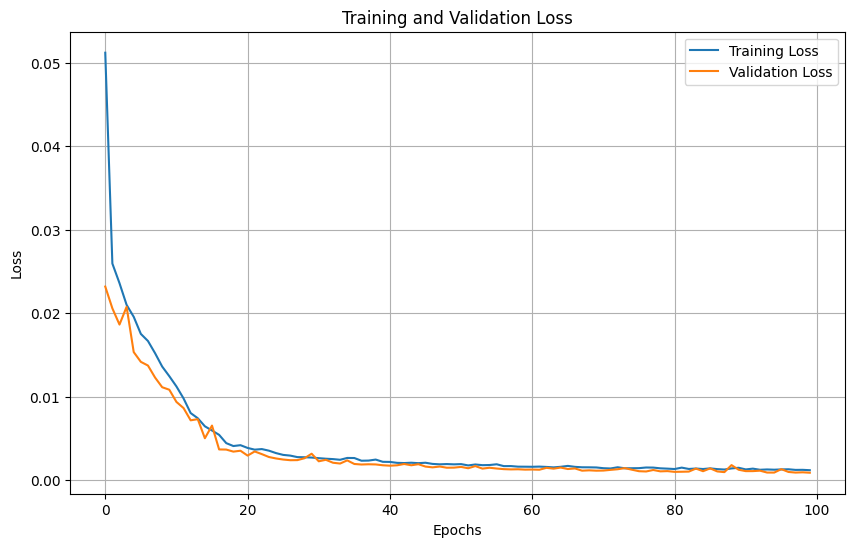

In [10]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend() 
plt.xlabel('Epochs') 
plt.ylabel('Loss')  
plt.title('Training and Validation Loss')    
plt.show() 

- evaluation based on suppressed original data 

In [21]:
import matplotlib.pyplot as plt

# Make predictions on the test set
EMD_predictions = model.predict(new_test_sequences) 

# Inverse scale the predictions and actual targets for comparison
EMD_predictions = scaler.inverse_transform(EMD_predictions)
EMD_actual_values = scaler.inverse_transform(new_test_targets.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error  
import numpy as np  

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(EMD_actual_values, EMD_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
mape = mean_absolute_percentage_error(EMD_actual_values, EMD_predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Root Mean Squared Error (RMSE): 3.5370696013804146
Mean Absolute Percentage Error (MAPE): 1.23%


- evaluation based on truely original dataset

In [30]:
import matplotlib.pyplot as plt

# Make predictions on the smoothed_test set
EMD_predictions = model.predict(new_test_sequences) 

# Make predictions on the original_test set
#EMD_predictions = model.predict(test_sequences) 

# Inverse scale the predictions and actual targets for comparison
EMD_predictions = scaler.inverse_transform(EMD_predictions)
actual_values = scaler.inverse_transform(test_targets.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, EMD_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_values, EMD_predictions) 
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Root Mean Squared Error (RMSE): 23.430007630099674
Mean Absolute Percentage Error (MAPE): 8.75%


- Create actual, LSTM values, GRU values, EMD-LSTM Dataframe
- let's see the dataframe

In [10]:
# Create a DataFrame for the testing set
test_datetime = test_data['datetime'].values[sequence_length:]  # Adjust for sequence offset

# Create the DataFrame with datetime, actual_values, and predictions
results_df = pd.DataFrame({
    'datetime': test_datetime,
    'actual_values': actual_values.flatten(),
    #'LSTM_predictions': predictions.flatten(),
    #'GRU_predictions' : GRU_predictions.flatten(),
    'EMD-LSTM_predictions' : EMD_predictions.flatten()
})
results_df

,datetime,actual_values,EMD-LSTM_predictions
0,2024-09-29 07:15:00,42438.0,238.756714
1,2024-09-29 07:20:00,42954.0,251.580795
2,2024-09-29 07:25:00,43814.0,244.694687
3,2024-09-29 07:30:00,44674.0,261.447632
4,2024-09-29 07:35:00,45018.0,254.749786
...,...,...,...
88,2024-09-29 14:35:00,37106.0,215.447220
89,2024-09-29 14:40:00,36074.0,208.286270
90,2024-09-29 14:45:00,35214.0,205.068954
91,2024-09-29 14:50:00,34698.0,199.597290


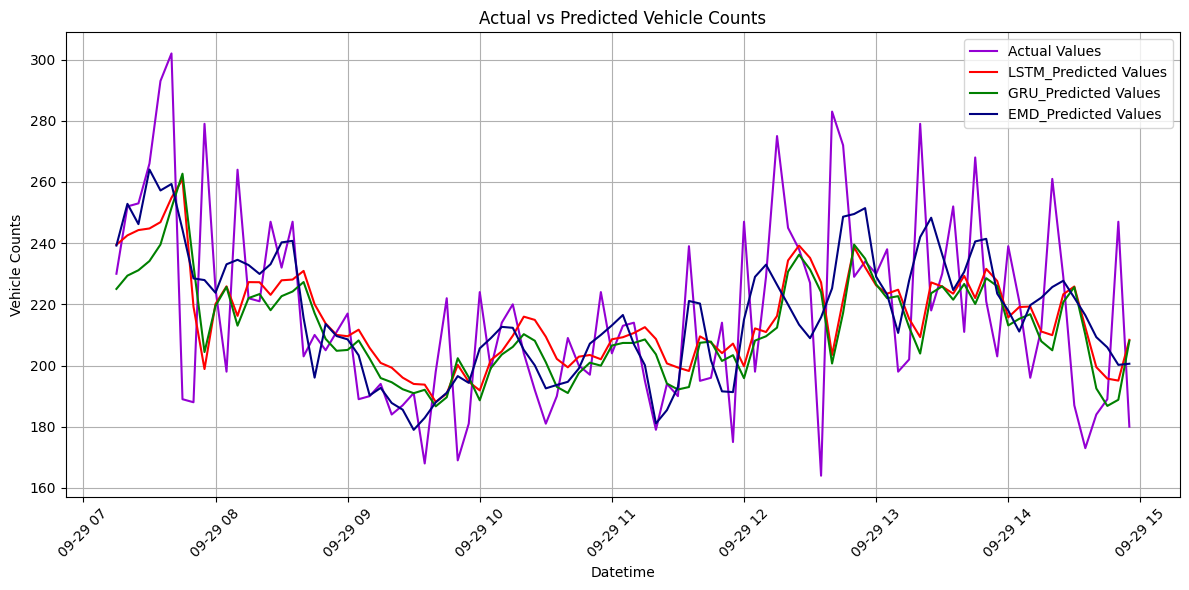

In [21]:
import matplotlib.pyplot as plt

# Plot Actual vs Prediction
plt.figure(figsize=(12, 6))
plt.plot(results_df['datetime'], results_df['actual_values'], label='Actual Values', color='darkviolet')
plt.plot(results_df['datetime'], results_df['LSTM_predictions'], label='LSTM_Predicted Values', color='red')
plt.plot(results_df['datetime'], results_df['GRU_predictions'], label='GRU_Predicted Values', color='green')
plt.plot(results_df['datetime'], results_df['EMD-LSTM_predictions'], label='EMD_Predicted Values', color='navy')
plt.title('Actual vs Predicted Vehicle Counts')
plt.xlabel('Datetime')
plt.ylabel('Vehicle Counts')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid()
plt.tight_layout()  
#plt.savefig('LSTM,GRU Actual Vs Predicted.png', format='png')  
plt.show() 

## ANN

In [12]:
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(
        units=hp.Int('input_unit', min_value=16, max_value=256, step=16),
        input_shape=(train_sequences.shape[1],),
        kernel_regularizer=l2(hp.Float('l2_regularizer', min_value=1e-5, max_value=1e-2, sampling='log')),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'], default='relu')
    ))
    
    # Hidden layers (1 or more based on tuning)
    for i in range(hp.Int('num_hidden_layers', 1, 3)):  # Tuning the number of hidden layers
        model.add(Dense(
            units=hp.Int(f'hidden_unit_{i}', min_value=16, max_value=256, step=16),
            activation=hp.Choice('hidden_activation', values=['relu', 'tanh', 'sigmoid'], default='relu'),
            kernel_regularizer=l2(hp.Float(f'hidden_l2_regularizer_{i}', min_value=1e-5, max_value=1e-2, sampling='log'))
        ))
        model.add(Dropout(hp.Float(f'Dropout_rate_{i}', min_value=0, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(1))  # Single output for regression
    
    # Learning rate tuning
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mean_squared_error", 
        metrics=["mse"]
    )
    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective="mse",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
)

# Perform hyperparameter tuning
tuner.search(
    x=train_sequences,
    y=train_targets,
    #validation_data=(val_sequences, val_targets),
    epochs=15,
    batch_size=16,
)

# Get the best hyperparameters after the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]  # Get the best trial

# Print the optimal hyperparameters
print("The optimal hyperparameters are:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

Trial 10 Complete [00h 00m 09s]
mse: 0.020876181311905384

Best mse So Far: 0.016018261201679707
Total elapsed time: 00h 01m 24s
The optimal hyperparameters are:
input_unit: 16
l2_regularizer: 4.03252709162638e-05
activation: relu
num_hidden_layers: 1
hidden_unit_0: 112
hidden_activation: tanh
hidden_l2_regularizer_0: 2.3032842242121426e-05
Dropout_rate_0: 0.0
lr: 0.0005656677780014923


- get best model, get prediction
- evaluate

In [13]:
best_model = tuner.get_best_models(num_models=1)[0] 

ANN_predictions = best_model.predict(test_sequences)
# Inverse scale the predictions and actual targets for comparison
ANN_predictions = scaler.inverse_transform(ANN_predictions)
actual_values = scaler.inverse_transform(test_targets.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, ANN_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_values, ANN_predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%") 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Root Mean Squared Error (RMSE): 29.79124000222553
Mean Absolute Percentage Error (MAPE): 10.21%


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## ConvLSTM 

In [14]:
# Define the Conv1D + LSTM model
model = Sequential([
    # Conv1D layer for feature extraction
    Conv1D(
        filters=64, 
        kernel_size=3,  # Convolution window size
        activation='relu',
        input_shape=(train_sequences.shape[1], 1),  # (time_steps, features)
        kernel_regularizer=l2(0.0001)
    ),
    
    # Add first LSTM layer
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)),

    # Add a second LSTM layer
    LSTM(32, kernel_regularizer=l2(0.0001)),

    # Dense output layer for regression
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_sequences, train_targets,
    validation_data=(val_sequences, val_targets),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1059 - val_loss: 0.0325
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0301 - val_loss: 0.0277
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0281 - val_loss: 0.0246
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0233 - val_loss: 0.0257
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0236 - val_loss: 0.0219
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0225 - val_loss: 0.0236
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0208 - val_loss: 0.0205
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0214 - val_loss: 0.0208
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0223 - val_loss: 0.0211
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0203 - val_loss: 0.0191
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0200 - val_loss: 0.0202
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

In [15]:
import matplotlib.pyplot as plt

# Make predictions on the test set
ConvLSTM_predictions = model.predict(test_sequences) 

# Inverse scale the predictions and actual targets for comparison
ConvLSTM_predictions = scaler.inverse_transform(ConvLSTM_predictions)
actual_values = scaler.inverse_transform(test_targets.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, ConvLSTM_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_values, ConvLSTM_predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
Root Mean Squared Error (RMSE): 28.791779339192793
Mean Absolute Percentage Error (MAPE): 9.58%


## Create dataframe of predicted results

In [33]:
# Create a DataFrame for the testing set
test_datetime = test_data['datetime'].values[sequence_length:]  # Adjust for sequence offset

# Create the DataFrame with datetime, actual_values, and predictions
results_df = pd.DataFrame({
    'datetime': test_datetime,
    'actual_values': actual_values.flatten(),
    'LSTM_predictions': predictions.flatten(),
    'GRU_predictions' : GRU_predictions.flatten(),
    'ANN_predictions': ANN_predictions.flatten(),
    'ConvLSTM_predictions': ConvLSTM_predictions.flatten(),
    'EMD_predictions': EMD_predictions.flatten(),
})
results_df

,datetime,actual_values,LSTM_predictions,GRU_predictions,ANN_predictions,ConvLSTM_predictions,EMD_predictions
0,2024-09-29 07:15:00,230.0,243.850708,216.711700,226.429352,230.575241,249.647308
1,2024-09-29 07:20:00,252.0,247.654556,221.638016,220.358047,229.633408,265.678772
2,2024-09-29 07:25:00,253.0,248.361832,228.528824,238.569458,233.538834,256.788300
3,2024-09-29 07:30:00,266.0,246.448563,232.443054,219.321548,240.038513,278.681030
4,2024-09-29 07:35:00,293.0,245.959564,238.156189,258.589355,246.870422,270.029999
...,...,...,...,...,...,...,...
88,2024-09-29 14:35:00,173.0,213.172409,206.198975,193.416840,207.983841,220.271866
89,2024-09-29 14:40:00,184.0,199.331741,191.678253,197.439407,196.226227,211.319305
90,2024-09-29 14:45:00,189.0,195.349823,185.924301,193.312164,192.901505,207.132980
91,2024-09-29 14:50:00,247.0,195.092636,185.419235,193.578201,192.592026,200.177155


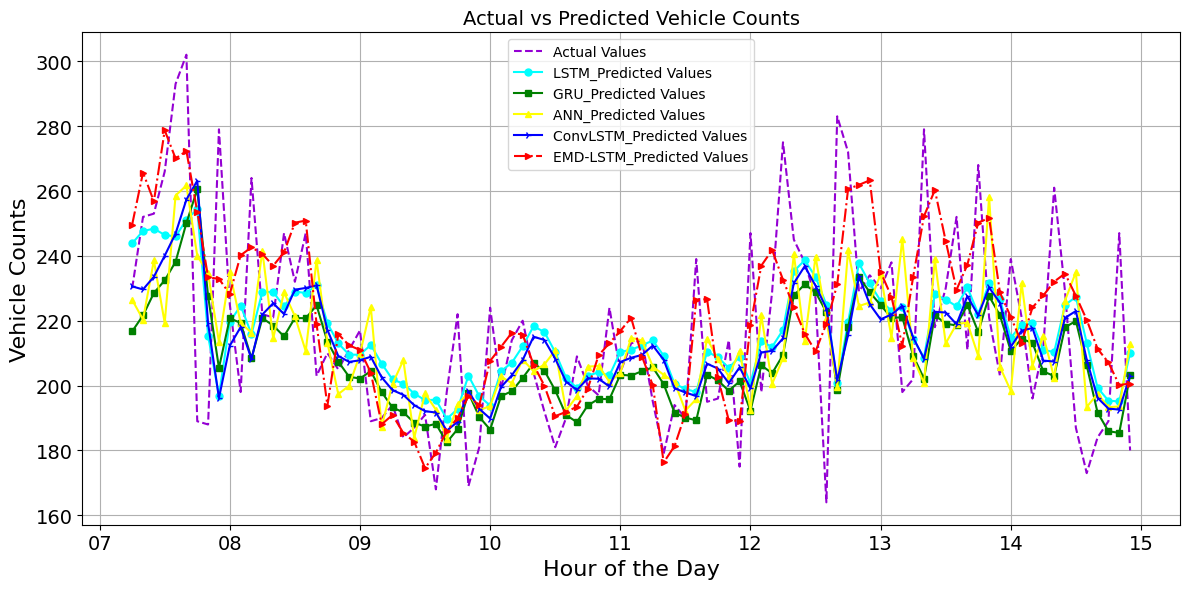

In [52]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot Actual vs Prediction
plt.figure(figsize=(12, 6))

# Actual values with dashed line
plt.plot(results_df['datetime'], results_df['actual_values'], label='Actual Values', color='darkviolet', linestyle='--')

# Predictions with different markers
plt.plot(results_df['datetime'], results_df['LSTM_predictions'], label='LSTM_Predicted Values', color='cyan', marker='o', markersize=5)
plt.plot(results_df['datetime'], results_df['GRU_predictions'], label='GRU_Predicted Values', color='green', marker='s', markersize=5)
plt.plot(results_df['datetime'], results_df['ANN_predictions'], label='ANN_Predicted Values', color='yellow', marker='^', markersize=5)
plt.plot(results_df['datetime'], results_df['ConvLSTM_predictions'], label='ConvLSTM_Predicted Values', color='blue', marker='4', markersize=5)
plt.plot(results_df['datetime'], results_df['EMD_predictions'], label='EMD-LSTM_Predicted Values', color='red', marker='>', markersize=5, linestyle='dashdot')

# Title and Labels
plt.title('Actual vs Predicted Vehicle Counts', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=16)  # X-axis label
plt.ylabel('Vehicle Counts', fontsize=16)   # Y-axis label

# Format x-axis to show only the hour
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))

# Increase tick label font size for x and y axes
plt.xticks(fontsize=14)  # X-axis tick labels
plt.yticks(fontsize=14)  # Y-axis tick labels

# Legend
plt.legend(fontsize=10)

# Grid and Layout
plt.grid()
plt.tight_layout()

# Show the plot
plt.savefig('Actual_Vs_Predicted_all_models_hourly.png', format='png')  # Uncomment to save
plt.show() 